# Install detectron2

In [ ]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

     |████████████████████████████████| 276kB 13.3MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44074 sha256=5f666f18ce8d86ab177ae516dd2043f567a65a072825d6a27093d609ad9dedbf
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.8.1+cu101 False
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.8)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.8")   # need to manually install torch 1.8 if Colab changes its default version
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
     |████████████████████████████████| 6.2MB 689kB/s 
     |████████████████████████████████| 51kB 4.9MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.3.post20210317-cp37-none-any.whl size=58543 sha256=89d95a2177e22b774d2ba4d9b90314c8b368d220319cd4768076131a5b4b83a6
  Stored in directory: /root/.cache/pip/wheels/d2/ee/3a/5c531df777c03d8c67f22c65f97d6f75321087482d05a9b218
Successfully built fvcore


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Run a pre-trained detectron2 model

Then, we create a detectron2 config and a detectron2 `DefaultPredictor` to run inference on this image.

In [ ]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

model_final_f10217.pkl: 178MB [00:15, 11.1MB/s]                           


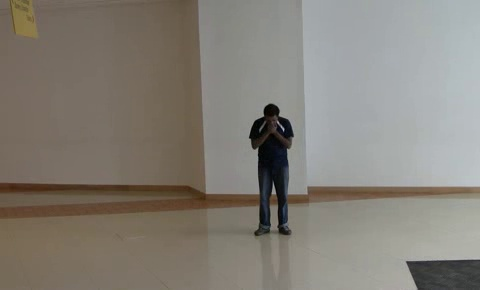

In [ ]:
im = cv2.imread("/content/drive/My Drive/cs231n/project/dataset/frames/train/S001_M_COUG_STD_FCE/frame3.jpg")
cv2_imshow(im)
outputs = predictor(im)

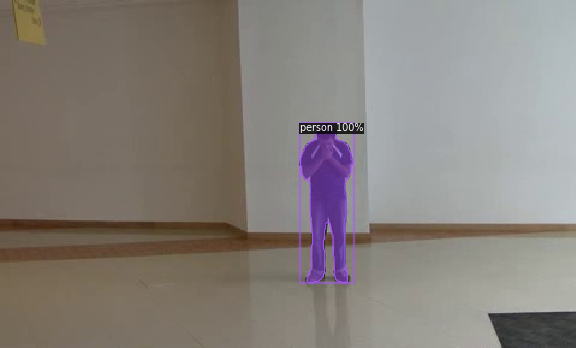

In [ ]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
from PIL import Image
import cv2
import math  

In [ ]:
#get prediction
outputs = predictor(im)

#get boxes and masks
ins = outputs["instances"]
(ins.get_fields()['pred_classes'] == 0).nonzero().flatten().tolist()

[0]

In [ ]:
def process_image(img, size, padColor = 255):
    
    h, w = img.shape[:2]
    border = 30
    sh, sw = size[0] - border*2, size[1] - border*2

    # interpolation method
    if h > sh or w > sw: # shrinking image
        interp = cv2.INTER_AREA
    else: # stretching image
        interp = cv2.INTER_CUBIC

    # aspect ratio of image
    aspect = w / h

    # compute scaling and pad sizing
    if aspect > 1: # horizontal image
        new_w = sw
        new_h = np.round(new_w/aspect).astype(int)
        pad_vert = (sh-new_h)/2
        pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
        pad_left, pad_right = 0, 0
    elif aspect < 1: # vertical image
        new_h = sh
        new_w = np.round(new_h*aspect).astype(int)
        pad_horz = (sw-new_w)/2
        pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
        pad_top, pad_bot = 0, 0
    else: # square image
        new_h, new_w = sh, sw
        pad_left, pad_right, pad_top, pad_bot = 0, 0, 0, 0

    # set pad color
    if len(img.shape) == 3 and not isinstance(padColor, (list, tuple, np.ndarray)): # color image but only one color provided
        padColor = [padColor]*3

    # scale and pad
    scaled_img = cv2.resize(img, (new_w, new_h), interpolation=interp)
    scaled_img = cv2.copyMakeBorder(scaled_img, pad_top+border, pad_bot+border, pad_left+border, pad_right+border, borderType=cv2.BORDER_CONSTANT, value=padColor)

    return scaled_img

In [ ]:
#function to get the cropped image.
def get_cropped_image(img, predictor, resize=None):
    #convert to numpy
    #img = np.array(img)[:,:,::-1]  # RGB -> BGR conversion
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    #img = np.array(img)
    
    #get prediction
    outputs = predictor(img)
    
    #get boxes and masks
    ins = outputs["instances"]
    
    # only care about person
    if 0 not in ins.get_fields()['pred_classes']:
      return
    matches = (ins.get_fields()['pred_classes'] == 0).nonzero().flatten().tolist()
    if len(matches) != 1:
      return
    idx = matches[0]
    pred_masks = ins.get_fields()["pred_masks"]
    
    #get main cart mask if the area is >= the mean area of boxes and is closes to the centre 
    mask = pred_masks[idx].to("cpu").numpy().astype(np.uint8)

    #mask image
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contour = contours[0]
    out = 255 - np.zeros_like(img)
    out[mask == 1] = img[mask == 1]

    # crop
    (y, x) = np.where(mask == 1)
    (topy, topx) = (np.min(y), np.min(x))
    (bottomy, bottomx) = (np.max(y), np.max(x))

    out = out[topy:bottomy+1, topx:bottomx+1]
    return cv2.cvtColor(process_image(out, (224, 224)), cv2.COLOR_BGR2RGB)
    #return process_image(out, (224, 224))

In [ ]:
img_path = "/content/drive/My Drive/cs231n/project/dataset/frames/train/S018_M_SNEE_STD_LFT/frame3.jpg"
img = get_cropped_image(cv2.imread(img_path), predictor, resize=None)

(224, 224, 3)


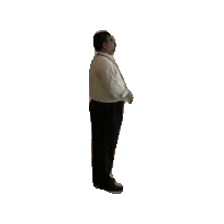

In [ ]:
if not img is None:
  print(img.shape)
  cv2_imshow(img)

In [ ]:
FOLDERNAME = 'cs231n/project/'
%cd /content/drive/My\ Drive/$FOLDERNAME
frames_path = 'dataset/cropped_frames/'
train_frames_path = os.path.join(frames_path, 'train')
test_frames_path = os.path.join(frames_path, 'test')
try:
    os.mkdir(frames_path)
except FileExistsError as ae:
    print('dataset/frames already created')
try:
    os.mkdir(train_frames_path)
except FileExistsError as ae:
    print('dataset/frames/train already created')
try:
    os.mkdir(test_frames_path)
except FileExistsError as ae:
    print('dataset/frames/test already created')

/content/drive/My Drive/cs231n/project
dataset/frames already created
dataset/frames/train already created
dataset/frames/test already created


In [ ]:
for s in ('train','test'):
  source_dir = "/content/drive/My Drive/cs231n/project/dataset/frames/"+s+'/'
  target_dir = "/content/drive/My Drive/cs231n/project/dataset/cropped_frames/"+s+'/'
  count = 0
  print('running: ' + s)
  for vid in sorted(os.listdir(source_dir)):
      # skip processed images
      if os.path.isdir(target_dir+vid):
        continue
      for filename in sorted(os.listdir(source_dir+vid)):
        # detect and crop
        source_path = os.path.join(source_dir, vid, filename)
        img = get_cropped_image(cv2.imread(source_path),
                                predictor, resize=None)
        # no person detected
        if img is None:
          continue
        # save img
        target_path = os.path.join(target_dir, vid, filename)
        if not cv2.imwrite(target_path, img):
          img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
          os.mkdir(os.path.join(target_dir, vid))
          cv2.imwrite(target_path, img)

## Split training and validation datasets

In [ ]:
import os
import pandas as pd
FOLDERNAME = 'cs231n/project/'
%cd /content/drive/My\ Drive/$FOLDERNAME

video_path = 'dataset/videos/'
videos = os.listdir(video_path)
subjects = []
actions =[]

for vid in videos:
  # Read index.
  subjects.append(vid[:4])
  # Read actions
  actions.append(vid.split('_')[2])

# Convert actions to 1 = flu sym, 0 = no flu sym.
mapping = {
    'CALL': 0,
    'COUG': 1,
    'DRIN': 0,
    'SCRA': 0,
    'SNEE': 1,
    'STRE': 0,
    'WAVE': 0,
    'WIPE': 0,
}
labels = [mapping[x] for x in actions]    

df_videos = pd.DataFrame({
    'video_subject': subjects,
    'video_name': videos,
    'action': actions,
    'label': labels
    
})
df_videos.head()

/content/drive/My Drive/cs231n/project


,video_subject,video_name,action,label
0,S019,S019_F_SCRA_STD_FCE_HF.avi,SCRA,0
1,S019,S019_F_WAVE_WLK_FCE_HF.avi,WAVE,0
2,S019,S019_F_COUG_WLK_FCE_HF.avi,COUG,1
3,S019,S019_F_WIPE_STD_RGT_HF.avi,WIPE,0
4,S019,S019_F_SCRA_STD_LFT_HF.avi,SCRA,0


In [ ]:
# Shuffle df_videos.
df_videos = df_videos.sample(frac=1, random_state=42).reset_index(drop=True)

df_videos_train = df_videos.loc[~df_videos['video_subject'].isin(
    ['S002','S003', 'S004', 'S005', 'S006'])].reset_index()
df_videos_test  = df_videos.loc[df_videos['video_subject'].isin(
    ['S002','S003', 'S004', 'S005', 'S006'])].reset_index()
print(df_videos_train.groupby('label').count())
print(df_videos_test.groupby('label').count())

       index  video_subject  video_name  action
label                                          
0       1080           1080        1080    1080
1        360            360         360     360
       index  video_subject  video_name  action
label                                          
0        360            360         360     360
1        120            120         120     120


In [ ]:
train_ratio = 0.70

label_1_dat = df_videos_train.loc[df_videos_train["label"]==1,]
label_0_dat = df_videos_train.loc[df_videos_train["label"]==0,]

train_len_label1 = int(len(label_1_dat)*train_ratio)
train_len_label0 = int(len(label_0_dat)*train_ratio)

train_dat_label1 = label_1_dat.iloc[:train_len_label1,]
train_dat_label0 = label_0_dat.iloc[:train_len_label0,]

val_dat_label1 = label_1_dat.iloc[train_len_label1:,]
val_dat_label0 = label_0_dat.iloc[train_len_label0:,]

train_dat = train_dat_label1.append(train_dat_label0, ignore_index=True)
val_dat = val_dat_label1.append(val_dat_label0, ignore_index=True)

In [ ]:
import collections

# See how many frames are captured for each video.
train_path='/content/drive/My Drive/cs231n/project/dataset/cropped_frames/train/'
test_path='/content/drive/My Drive/cs231n/project/dataset/cropped_frames/test/'

vid_file_name=df_videos_train.video_name[0].split('.')[0]

train_frames = collections.defaultdict(list)
for i in range(len(df_videos_train.video_name)):
    print(i)
    vid_file_name=df_videos_train.video_name[i].split('.')[0]
    train_frames[vid_file_name.split('_')[2]].append(len(os.listdir(os.path.join(train_path, vid_file_name))))



In [ ]:
frame_len_df = pd.DataFrame(train_frames)
frame_len_df.to_csv('frame_len_df.csv')

In [ ]:
frame_len_df.describe()

,CALL,COUG,WAVE,WIPE,SNEE,DRIN,SCRA,STRE
count,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000
mean,15.900000,14.450000,12.483333,17.972222,12.222222,15.100000,13.766667,13.794444
std,3.242697,4.310925,2.164918,2.240886,2.876519,2.832572,2.711655,2.231559
min,10.000000,9.000000,9.000000,14.000000,7.000000,10.000000,9.000000,9.000000
25%,14.000000,12.000000,11.000000,16.000000,10.000000,13.000000,12.000000,12.000000
50%,15.000000,14.000000,12.000000,18.000000,12.000000,14.000000,14.000000,14.000000
75%,18.000000,16.000000,14.000000,20.000000,14.000000,17.000000,16.000000,15.000000
max,25.000000,37.000000,19.000000,23.000000,20.000000,22.000000,21.000000,20.000000


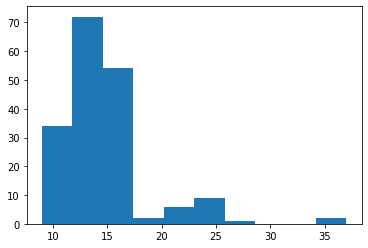

In [ ]:
import matplotlib.pyplot as plt

plt.hist(train_frames['COUG'])
plt.show()


## Making sure that each video has at least x frames

Some videos are short and the frames captured from them are less than x. We will generate extra frames by creating copies of the last frame and put them at the end. This is to make sure that we have at least x frames in each video.

In [ ]:
import shutil

def extend_frames(dataset, dir_path):
    x = 16
    for i in range(len(dataset.video_name)):
        print(i)
        vid_namu = dataset.video_name[i]
        vid_path = os.path.join(dir_path,vid_namu.split(".")[0])
        len_frame = len(os.listdir(vid_path))
        j = x - len(os.listdir(vid_path))
        if j > 0:
            list_frames = os.listdir(vid_path)
            c = 0
            countu = 91
            for k in range(j):
                list_frames=os.listdir(vid_path)
                frame=os.path.join(vid_path, list_frames[c])
                new_frame="frame%d.jpg" % countu
                shutil.copy2(frame,os.path.join(vid_path,new_frame))
                countu += 1
                c += 1
        else:
            pass
    return print("Frame Generation Done!")
    
train_path='/content/drive/My Drive/cs231n/project/dataset/cropped_frames/train/'
test_path='/content/drive/My Drive/cs231n/project/dataset/cropped_frames/test/'

extend_frames(df_videos_train, train_path)
extend_frames(df_videos_test, test_path)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75


## Create frame datasets

Function below extracts the first x frames for each video, resize each frame into (224,224) image and convert it into greyscale image.

In [ ]:
# Output directory.
output_path = "/content/drive/My Drive/cs231n/project/dataset/shaped_cropped_data/"

# Save final dataset.
try:
    os.mkdir(output_path)
except FileExistsError:
    pass

In [ ]:
from PIL import Image
import numpy as np

def create_frame_dataset(dataset, input_path, output_path):
    x = 16
    frames = []
    for i in np.arange(len(dataset)):
        if i % 100 == 0: print(f'Progress: {i} / {len(dataset)}')
        vid_name = dataset.video_name[i].split(".")[0]
        vid_dir_path = os.path.join(input_path, vid_name)
        frames_to_select = []
        list_frames = os.listdir(vid_dir_path)
        for img in list_frames[:x]:
            frames_to_select.append(img)
        vid_data=[]
        for frame in frames_to_select:
            image = Image.open(os.path.join(vid_dir_path,frame))
            datu = np.asarray(image)
            normu_dat = datu/255
            vid_data.append(normu_dat)
        vid_data = np.array(vid_data)
        frames.append(vid_data)
    dataset_new = np.array(frames)
    dataset_new = dataset_new.reshape((dataset_new.shape[0],x,224,224,3))
    labels = np.array(dataset.label)
    actions = np.array(dataset.action)
    return dataset_new, labels, actions

In [ ]:
# Training dataset.
input_path='/content/drive/My Drive/cs231n/project/dataset/cropped_frames1/train/'
dataset_new, labels, actions = create_frame_dataset(train_dat, input_path, output_path)
np.save(os.path.join(output_path, "train_data"), dataset_new)
np.save(os.path.join(output_path, "train_labels"), labels)
np.save(os.path.join(output_path, "train_actions"), actions)

Progress: 0 / 1007


KeyboardInterrupt: ignored

In [ ]:
# Validation dataset.
input_path='/content/drive/My Drive/cs231n/project/dataset/cropped_frames1/train/'
dataset_new, labels, actions = create_frame_dataset(val_dat, input_path, output_path)
np.save(os.path.join(output_path, "val_data"), dataset_new)
np.save(os.path.join(output_path, "val_labels"), labels)
np.save(os.path.join(output_path, "val_actions"), actions)

In [ ]:
# Test dataset.
input_path='/content/drive/My Drive/cs231n/project/dataset/cropped_frames1/test/'
dataset_new, labels, actions = create_frame_dataset(df_videos_test, input_path, output_path)
np.save(os.path.join(output_path, "test_data"), dataset_new)
np.save(os.path.join(output_path, "test_labels"), labels)
np.save(os.path.join(output_path, "test_actions"), actions)